In [7]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def decompose_series(df):
    return sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)

def check_stationarity(series):
    result = adfuller(series)
    return {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4]
    }

def plot_acf_pacf(series, lags=30):
    fig_acf = sm.graphics.tsa.plot_acf(series, lags=lags)
    fig_pacf = sm.graphics.tsa.plot_pacf(series, lags=lags)
    return fig_acf, fig_pacf

import yfinance as yf
import pandas as pd

def fetch_stock_data(ticker, start_date, end_date, interval, save_as="Data.csv"):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)

    data.reset_index(inplace=True)
    
    data.to_csv(save_as, index=False)


def load_data_from_csv(filepath="Data.csv"):
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[numeric_cols].dropna()
    return df

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(df, order=(5, 1, 0), steps=30):
    model = ARIMA(df['Close'], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=steps)
    return pd.Series(forecast.values, index=future_dates)

def random_forest_forecast(df, future_days=30):
    df = df.copy()
    required_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing columns. Required: {required_cols}")

    df['Target'] = df['Close'].shift(-future_days)
    df.dropna(inplace=True)

    X = df[['Open', 'High', 'Low', 'Volume']]
    y = df['Target']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    last_known = df[['Open', 'High', 'Low', 'Volume']].tail(future_days).copy()
    if len(last_known) < future_days:
        last_row = last_known.iloc[-1]
        for _ in range(future_days - len(last_known)):
            last_known = pd.concat([last_known, last_row.to_frame().T], ignore_index=True)

    future_pred = model.predict(last_known)
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)
    return pd.Series(future_pred, index=future_dates)

import matplotlib.pyplot as plt
import pandas as pd

def plot_time_series(df):
    fig, ax = plt.subplots(figsize=(12, 5))
    if 'Close' not in df.columns:
        raise ValueError("Column 'Close' not found in DataFrame")
    df['Close'].plot(ax=ax, title="Stock Closing Price")
    ax.set_ylabel("Price")
    ax.grid(True)
    return fig

def plot_forecast(df, forecast_series, title="Forecast"):
    fig, ax = plt.subplots(figsize=(12, 5))
    forecast_series.plot(ax=ax, color='orange', label='Forecast')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Predicted Close Price")
    ax.legend()
    ax.grid(True)
    return fig

def plot_decomposition(decomposition):
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    return fig


In [8]:
import streamlit as st
from datetime import datetime, date
from utilities.data import fetch_stock_data, load_data_from_csv
from utilities.analysis import decompose_series, check_stationarity, plot_acf_pacf
from utilities.model import arima_forecast, random_forest_forecast
from utilities.plot import plot_time_series, plot_forecast, plot_decomposition

st.set_page_config(page_title="📈 Stock Forecasting App", layout="wide")
st.title("📈 Stock Price Forecasting App")

st.sidebar.header("⚙️ Settings")
ticker = st.sidebar.text_input("Enter stock ticker", value="AAPL")
start_date = st.sidebar.date_input("Start Date", value=datetime(2010, 1, 1).date())
end_date = st.sidebar.date_input("End Date", value=date.today(), max_value=date.today())
days_to_forecast = st.sidebar.slider("Forecast Days", min_value=10, max_value=100, value=30)

model_choice = st.sidebar.radio("Choose Forecasting Model", ("ARIMA", "Random Forest"))

if st.sidebar.button("🔄 Run Forecast"):
    with st.spinner("Fetching data and building forecast..."):
        fetch_stock_data(ticker, start_date=start_date, end_date=end_date)
        df = load_data_from_csv()

        with st.expander("🗃 Raw Data"):
            st.dataframe(df.tail())

        st.subheader("📊 Historical Time Series")
        st.pyplot(plot_time_series(df))

        st.subheader("🧩 Time Series Decomposition")
        decomposition = decompose_series(df)
        st.pyplot(plot_decomposition(decomposition))

        st.subheader("📉 ADF Test (Stationarity Check)")
        adf_result = check_stationarity(df['Close'])
        st.write(adf_result)

        st.subheader("📐 ACF & PACF Plots")
        acf_fig, pacf_fig = plot_acf_pacf(df['Close'])
        st.pyplot(acf_fig)
        st.pyplot(pacf_fig)

        st.subheader(f"🔮 {model_choice} Forecast - Next {days_to_forecast} Days")
        if model_choice == "ARIMA":
            forecast_series = arima_forecast(df, steps=days_to_forecast)
        else:
            forecast_series = random_forest_forecast(df, future_days=days_to_forecast)

        st.pyplot(plot_forecast(df, forecast_series, title=f"{model_choice} Forecast"))
        st.success("✅ Forecast complete!")

import matplotlib.pyplot as plt
from utilities.data import fetch_stock_data, load_data_from_csv
from utilities.analysis import decompose_series
from utilities.plot import plot_time_series, plot_decomposition, plot_forecast
from utilities.model import arima_forecast

def main():
    print("📈 Welcome to the Stock Forecast CLI App")

    ticker = input("🔹 Enter stock ticker (default = AAPL): ").upper() or "AAPL"

    try:
        days = int(input("🔹 Enter number of days to forecast (default = 30): ") or 30)
    except ValueError:
        print("⚠️ Invalid input. Using default 30 days.")
        days = 30

    print(f"\n📦 Fetching stock data for {ticker}...")
    fetch_stock_data(ticker)

    print("📊 Loading and processing data...")
    df = load_data_from_csv()

    print("📈 Plotting time series...")
    ts_fig = plot_time_series(df)
    ts_fig.savefig(f"{ticker}_timeseries.png")

    print("🧩 Decomposing time series...")
    decomposition = decompose_series(df)
    decomp_fig = plot_decomposition(decomposition)
    decomp_fig.savefig(f"{ticker}_decomposition.png")

    print(f"🔮 Forecasting next {days} days using ARIMA...")
    forecast_series = arima_forecast(df, steps=days)
    forecast_fig = plot_forecast(df, forecast_series, title=f"{ticker} Forecast (ARIMA)")
    forecast_fig.savefig(f"{ticker}_forecast.png")

    print("\n✅ Done!")
    print(f"📂 Files saved:\n- {ticker}_timeseries.png\n- {ticker}_decomposition.png\n- {ticker}_forecast.png")

if __name__ == "__main__":
    main()
streamlit
yfinance
pandas
numpy
matplotlib
scikit-learn
statsmodels

ModuleNotFoundError: No module named 'utilities'


📊 Basic Statistics:
              Open         High          Low        Close        Volume
count  1006.000000  1006.000000  1006.000000  1006.000000  1.006000e+03
mean    138.247375   139.863375   136.743543   138.377811  9.895373e+07
std      33.453056    33.579798    33.319774    33.459340  5.439610e+07
min      55.277751    55.379543    51.528423    54.378590  2.404830e+07
25%     120.869277   122.008187   119.225845   120.763407  6.407675e+07
50%     143.100283   144.829642   141.584413   143.250984  8.467540e+07
75%     163.960268   165.974635   162.434227   163.691666  1.155069e+08
max     196.580427   198.168786   195.567819   196.669769  4.265100e+08

ℹ️ DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1006 non-null   float64
 1   High    1006 non-null   float64
 2   Low     1006 non-null   float64
 3

C:\Users\nupur\AppData\Local\Temp\ipykernel_4228\3769050563.py:26: FutureWarning:

YF.download() has changed argument auto_adjust default to True

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.4.12 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



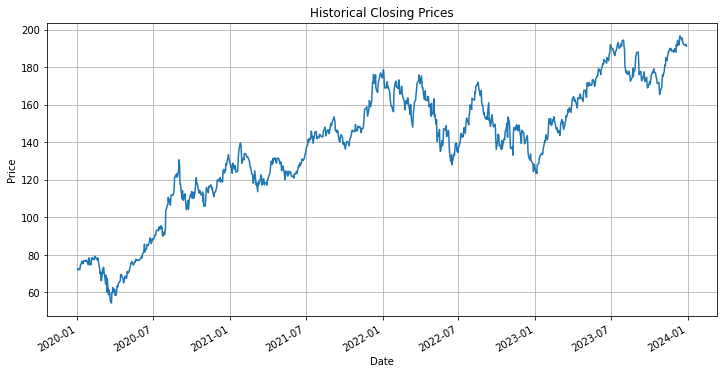

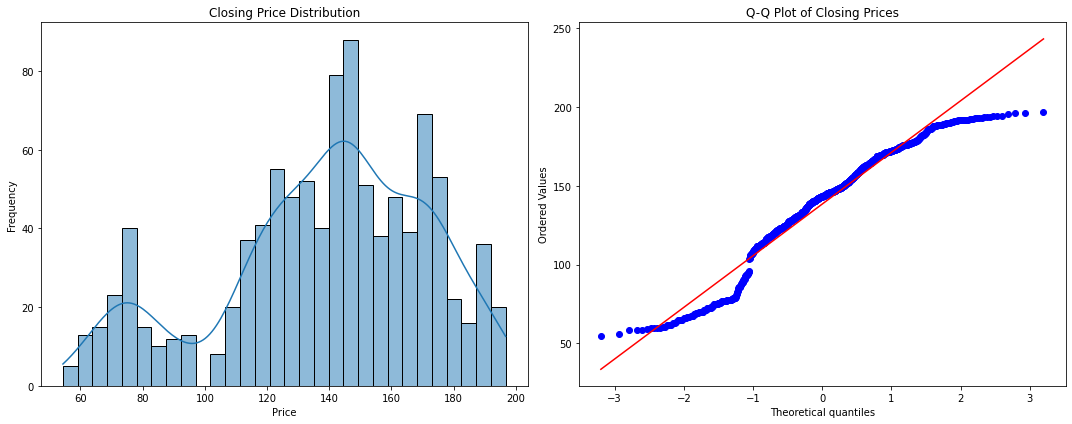

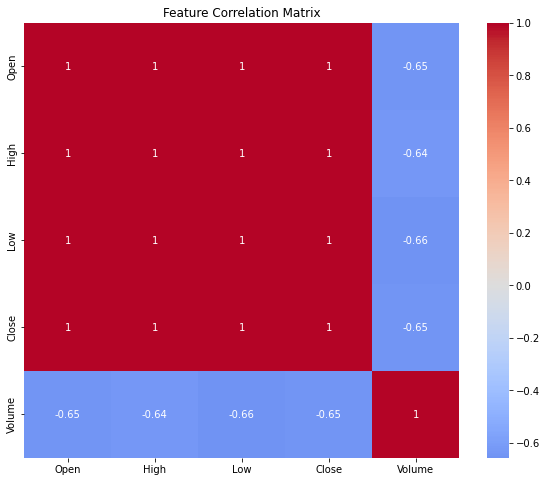

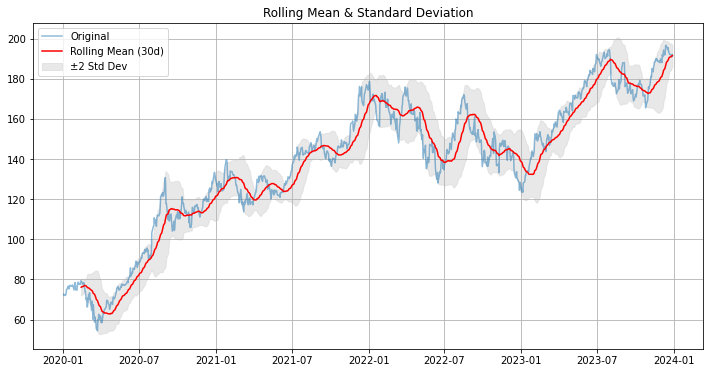

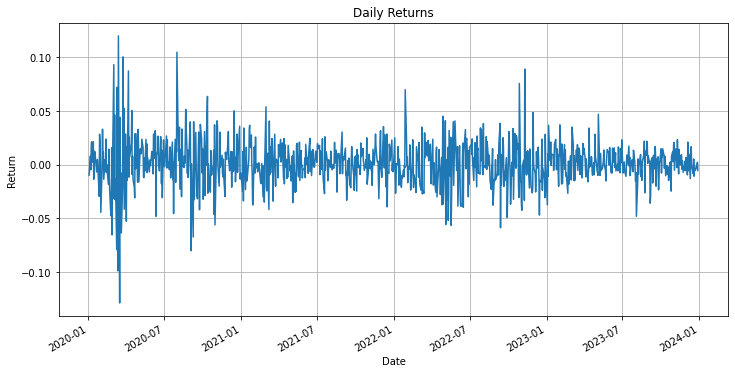

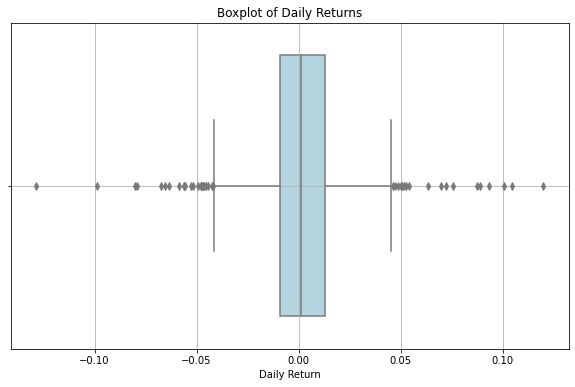


📉 ADF Test Results:
{'ADF Statistic': -1.5119511072779772, 'p-value': 0.5275912308336577, 'Critical Values': {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}}


C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



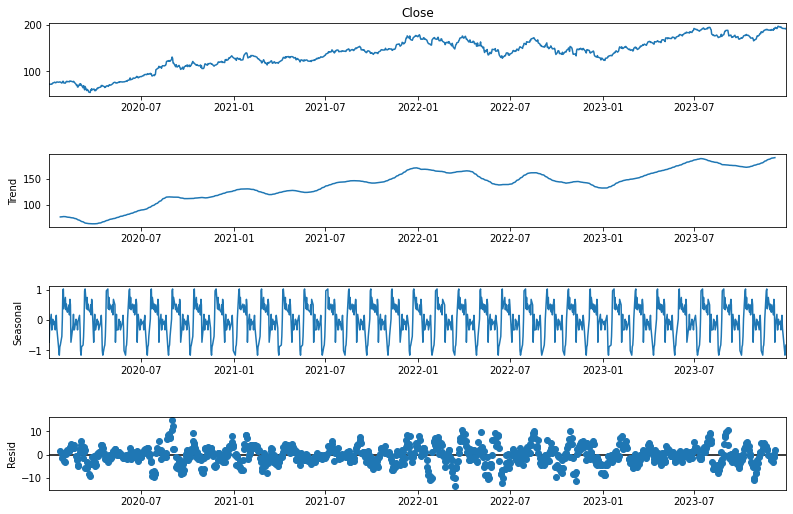

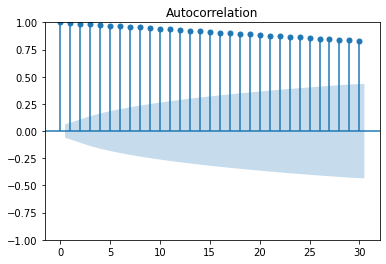

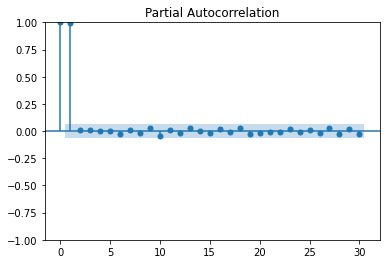

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



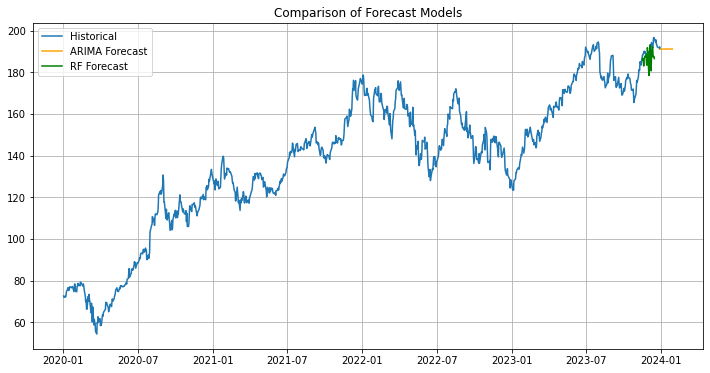

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go

def display_basic_stats(df):
    """Display basic statistics and information about the DataFrame"""
    print("\n📊 Basic Statistics:")
    print(df.describe())
    
    print("\nℹ️ DataFrame Info:")
    print(df.info())
    
    print("\n🔍 Missing Values:")
    print(df.isnull().sum())

def plot_candlestick(df):
    """Plot candlestick chart for stock prices"""
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                           open=df['Open'],
                                           high=df['High'],
                                           low=df['Low'],
                                           close=df['Close'])])
    fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
    fig.show()

def plot_price_distribution(df):
    """Plot distribution of closing prices with Q-Q plot"""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['Close'], kde=True, bins=30)
    plt.title('Closing Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df['Close'], plot=plt)
    plt.title('Q-Q Plot of Closing Prices')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    """Plot correlation heatmap for numerical columns"""
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Feature Correlation Matrix')
    plt.show()

def analyze_rolling_stats(df, window=30):
    """Calculate and visualize rolling statistics"""
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Original', alpha=0.5)
    plt.plot(rolling_mean, label=f'Rolling Mean ({window}d)', color='red')
    plt.fill_between(df.index, 
                     rolling_mean - 2 * rolling_std, 
                     rolling_mean + 2 * rolling_std, 
                     color='lightgray', alpha=0.5, label='±2 Std Dev')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rolling_mean, rolling_std

def plot_boxplot(df):
    """Plot boxplot for daily returns"""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Daily_Return'], color='lightblue')
    plt.title('Boxplot of Daily Returns')
    plt.xlabel('Daily Return')
    plt.grid(True)
    plt.show()

def perform_eda(df):
    """Comprehensive EDA for stock data"""
    display_basic_stats(df)
    
    plot_candlestick(df)
    
    plt.figure(figsize=(12, 6))
    df['Close'].plot()
    plt.title('Historical Closing Prices')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    plot_price_distribution(df)
    
    plot_correlation_heatmap(df)
    
    rolling_mean, rolling_std = analyze_rolling_stats(df)
  
    df['Daily_Return'] = df['Close'].pct_change()
    
    plt.figure(figsize=(12, 6))
    df['Daily_Return'].plot()
    plt.title('Daily Returns')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()
    
    plot_boxplot(df)
    
    return df, rolling_mean, rolling_std

if __name__ == "__main__":
    # Fetch and load data
    ticker = "AAPL"
    start_date = "2020-01-01"
    end_date = "2023-12-31"
    
    fetch_stock_data(ticker, start_date, end_date, interval="1d")
    df = load_data_from_csv()
    
    # Comprehensive EDA
    enhanced_df, rolling_mean, rolling_std = perform_eda(df)
    
    decomposition = decompose_series(enhanced_df)
    plot_decomposition(decomposition)
    
    adf_result = check_stationarity(enhanced_df['Close'])
    print("\n📉 ADF Test Results:")
    print(adf_result)
    
    acf_fig, pacf_fig = plot_acf_pacf(enhanced_df['Close'])
    plt.show()
    
    # Forecasting 
    arima_forecast_result = arima_forecast(enhanced_df)
    random_forest_forecast_result = random_forest_forecast(enhanced_df)
    
    plt.figure(figsize=(12, 6))
    plt.plot(enhanced_df['Close'], label='Historical')
    plt.plot(arima_forecast_result, label='ARIMA Forecast', color='orange')
    plt.plot(random_forest_forecast_result, label='RF Forecast', color='green')
    plt.title('Comparison of Forecast Models')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
def load_data_from_csv(filepath="Data.csv"):
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[numeric_cols].dropna()
    
    # Set frequency to daily
    df = df.asfreq('D')
    
    return df



📊 Basic Statistics:
              Open         High          Low        Close        Volume
count  1006.000000  1006.000000  1006.000000  1006.000000  1.006000e+03
mean    138.247375   139.863375   136.743543   138.377811  9.895373e+07
std      33.453056    33.579798    33.319774    33.459340  5.439610e+07
min      55.277751    55.379543    51.528423    54.378590  2.404830e+07
25%     120.869277   122.008187   119.225845   120.763407  6.407675e+07
50%     143.100283   144.829642   141.584413   143.250984  8.467540e+07
75%     163.960268   165.974635   162.434227   163.691666  1.155069e+08
max     196.580427   198.168786   195.567819   196.669769  4.265100e+08

ℹ️ DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2020-01-02 to 2023-12-29
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1006 non-null   float64
 1   High    1006 non-null   float64
 2   Low     1006 non-null   fl

C:\Users\nupur\AppData\Local\Temp\ipykernel_4228\586097728.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

C:\Users\nupur\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.4.12 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



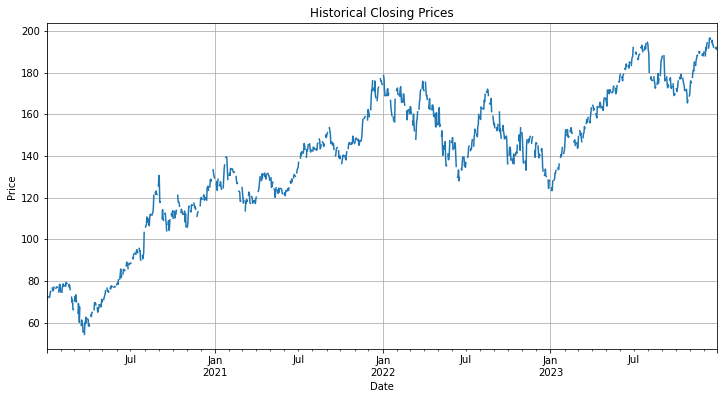

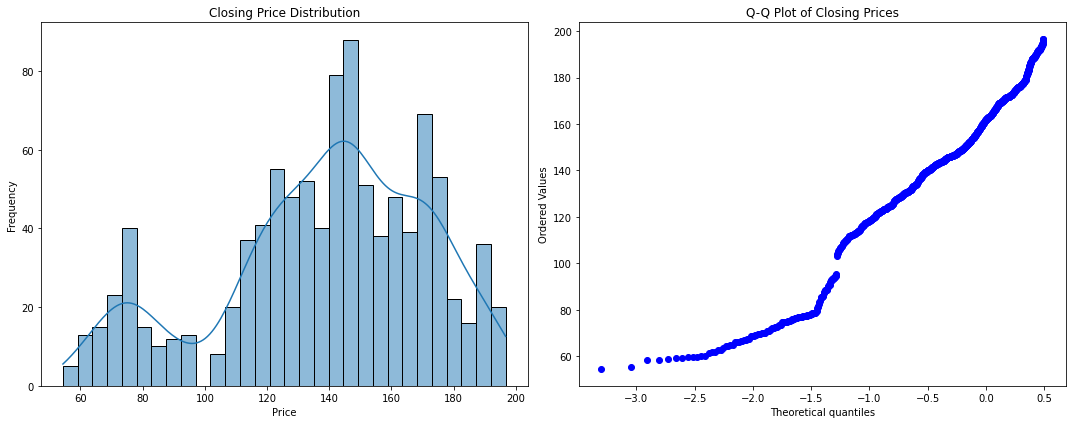

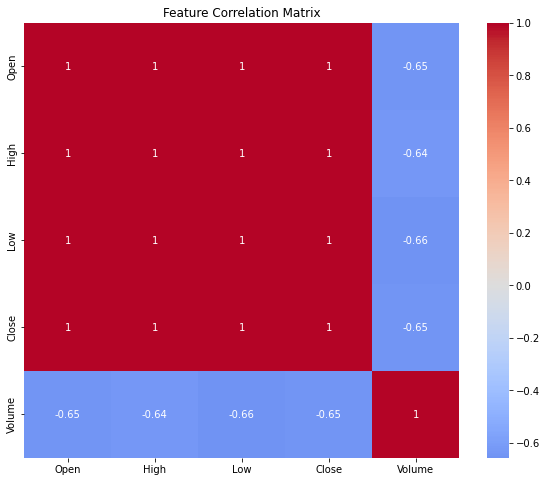

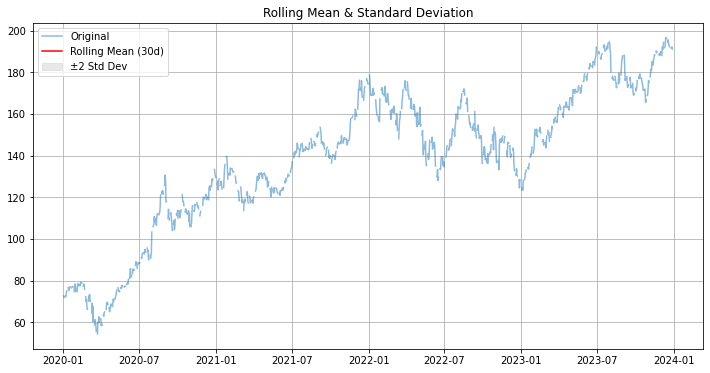

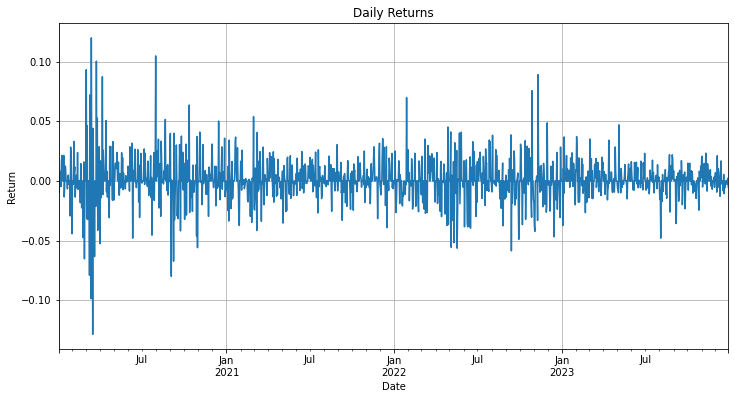

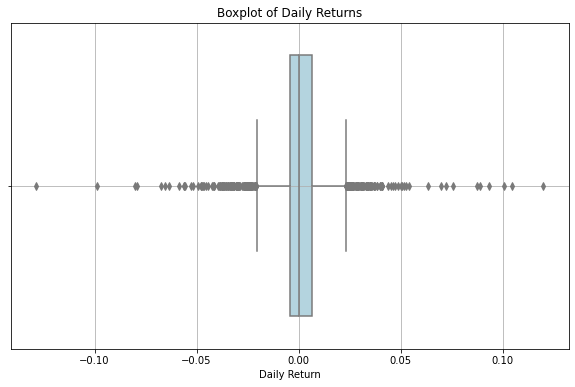

Missing values found in 'Close' column. Filling missing values.


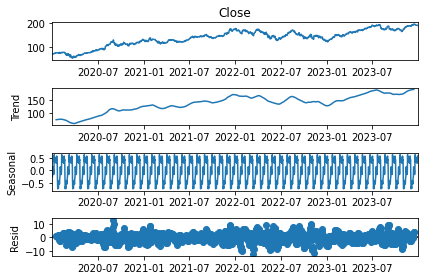


📉 ADF Test Results:
(-1.4818744663206043, 0.5424579695876554, 1, 1456, {'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}, 6291.29617436355)


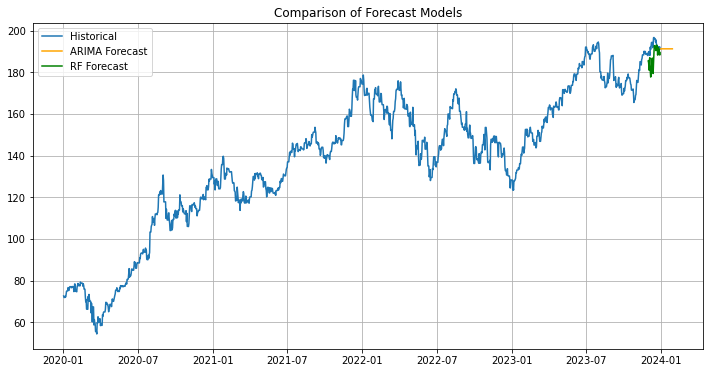

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go

def fetch_stock_data(ticker, start_date, end_date, interval, save_as="Data.csv"):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
    data.reset_index(inplace=True)
    data.to_csv(save_as, index=False)

def load_data_from_csv(filepath="Data.csv"):
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[numeric_cols].dropna()
    
    # Set frequency to daily
    df = df.asfreq('D')
    
    return df

def display_basic_stats(df):
    """Display basic statistics and information about the DataFrame"""
    print("\n📊 Basic Statistics:")
    print(df.describe())
    
    print("\nℹ️ DataFrame Info:")
    print(df.info())
    
    print("\n🔍 Missing Values:")
    print(df.isnull().sum())

def plot_candlestick(df):
    """Plot candlestick chart for stock prices"""
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                           open=df['Open'],
                                           high=df['High'],
                                           low=df['Low'],
                                           close=df['Close'])])
    fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
    fig.show()

def plot_price_distribution(df):
    """Plot distribution of closing prices with Q-Q plot"""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['Close'], kde=True, bins=30)
    plt.title('Closing Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df['Close'], plot=plt)
    plt.title('Q-Q Plot of Closing Prices')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    """Plot correlation heatmap for numerical columns"""
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Feature Correlation Matrix')
    plt.show()

def analyze_rolling_stats(df, window=30):
    """Calculate and visualize rolling statistics"""
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Original', alpha=0.5)
    plt.plot(rolling_mean, label=f'Rolling Mean ({window}d)', color='red')
    plt.fill_between(df.index, 
                     rolling_mean - 2 * rolling_std, 
                     rolling_mean + 2 * rolling_std, 
                     color='lightgray', alpha=0.5, label='±2 Std Dev')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rolling_mean, rolling_std

def plot_boxplot(df):
    """Plot boxplot for daily returns"""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Daily_Return'], color='lightblue')
    plt.title('Boxplot of Daily Returns')
    plt.xlabel('Daily Return')
    plt.grid(True)
    plt.show()

def perform_eda(df):
    """Comprehensive EDA for stock data"""
    display_basic_stats(df)
    
    plot_candlestick(df)
    
    plt.figure(figsize=(12, 6))
    df['Close'].plot()
    plt.title('Historical Closing Prices')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    plot_price_distribution(df)
    
    plot_correlation_heatmap(df)
    
    rolling_mean, rolling_std = analyze_rolling_stats(df)
  
    df['Daily_Return'] = df['Close'].pct_change()
    
    plt.figure(figsize=(12, 6))
    df['Daily_Return'].plot()
    plt.title('Daily Returns')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()
    
    plot_boxplot(df)
    
    return df, rolling_mean, rolling_std

if __name__ == "__main__":
    # Fetch and load data
    ticker = "AAPL"
    start_date = "2020-01-01"
    end_date = "2023-12-31"
    
    fetch_stock_data(ticker, start_date, end_date, interval="1d")
    df = load_data_from_csv()
    
    # Comprehensive EDA
    enhanced_df, rolling_mean, rolling_std = perform_eda(df)
    
    # Check for missing values before decomposition
    if enhanced_df['Close'].isnull().any():
        print("Missing values found in 'Close' column. Filling missing values.")
        enhanced_df['Close'].fillna(method='ffill', inplace=True)  

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(enhanced_df['Close'], model='additive', period=30)
    decomposition.plot()
    plt.show()
    
    adf_result = adfuller(enhanced_df['Close'])
    print("\n📉 ADF Test Results:")
    print(adf_result)
    
    # Forecasting 
    arima_forecast_result = arima_forecast(enhanced_df)
    random_forest_forecast_result = random_forest_forecast(enhanced_df)
    
    plt.figure(figsize=(12, 6))
    plt.plot(enhanced_df['Close'], label='Historical')
    plt.plot(arima_forecast_result, label='ARIMA Forecast', color='orange')
    plt.plot(random_forest_forecast_result, label='RF Forecast', color='green')
    plt.title('Comparison of Forecast Models')
    plt.legend()
    plt.grid(True)
    plt.show()
